<h1 align="center">
<strong>Projet Télédétection Avancée</strong>
</h1>

**Marion BILLY**

**Bretagne 24-25**

> créer un diagramme de flux

# 1. 

### Import des bibliothèques

In [24]:
import sys
import os
from osgeo import gdal
gdal.UseExceptions()
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

sys.path.append("/home/onyxia/work")
from libsigma import read_and_write as rw
from libsigma import classification as cla
from libsigma import plots

### Définition des chemins

In [2]:
data_path = '/home/onyxia/work/data/projet_eval'
results_path = '/home/onyxia/work/results'
figure_path = '/home/onyxia/work/results/figure'

---

# 2. Analyse des échantillons

## 2.1. Nombre d'échantillons

### 2.1.1 Diagramme en bâton du nombre de polygones par classe

In [3]:
gdf = gpd.read_file(os.path.join(data_path, "PI_strates_bretagne_32630.shp"))
strates = [1, 2, 3, 4]
labels_strates = {1: "Sols Nus", 2: "Herbes", 3: "Landes", 4: "Arbres"}
colors_strates = {1: 'peru', 2: 'goldenrod', 3: 'lightgreen', 4: 'forestgreen'}

# Compter le nombre de polygones par strate
nb_poly = gdf["strate"].value_counts().sort_index()
# Diagramme en bâton
plt.figure()
bars= plt.bar(
    x=[labels_strates[s] for s in nb_poly.index],
    height=nb_poly.values,
    color=[colors_strates[s] for s in nb_poly.index])
# Nombre de polygones au-dessus des barres
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        int(bar.get_height()),
        ha='center',)

plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par strate")
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "diag_baton_nb_poly_by_class.png"), dpi=300)
plt.close()

### 2.1.2 Diagramme en bâton du nombre de pixel par classe

#### Rasterisation

On transforme le shapefile des échantillons en raster. Le raster a la même taille et la même résolution spatiale qu'une image Sentinel-2 de référence. Cela permet ensuite d'extraire facilement avec Numpy le nombre de pixels correspondant à chaque strate.

In [4]:
in_vector = os.path.join(data_path, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(data_path, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif')
field_name = 'strate'  # attribut contenant les classes numériques

# Infos de l'image de référence
ref_image = rw.open_image(ref_image)
nb_lignes, nb_col, _ = rw.get_image_dimension(ref_image)
origin_x, origin_y = rw.get_origin_coordinates(ref_image)
psize_x, psize_y = rw.get_pixel_size(ref_image)

xmin, xmax = origin_x, origin_x + nb_col * psize_x
ymax, ymin = origin_y, origin_y + nb_lignes * psize_y
sptial_res = abs(psize_x)

print("Spatial resolution :", sptial_res)
print("Extent : xmin =", xmin, "ymin =", ymin, "xmax =", xmax, "ymax =", ymax)

# Rasterisation avec GDAL (terminal)
cmd = (
    f"gdal_rasterize -a {field_name} "
    f"-tr {sptial_res} {sptial_res} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    f"-ot Byte -of GTiff "
    f"{in_vector} {out_image}")
os.system(cmd)

Spatial resolution : 10.0
Extent : xmin = 432950.0 ymin = 5362770.0 xmax = 448280.0 ymax = 5368890.0
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [5]:
roi_raster = os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif')
strates = [1, 2, 3, 4]
labels_strates = {1: "Sols Nus", 2: "Herbes", 3: "Landes", 4: "Arbres"}
colors_strates = {1: 'peru', 2: 'goldenrod', 3: 'lightgreen', 4: 'forestgreen'}

# Extraire X (valeurs des pixels), Y (labels), t (coordonnées)
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)

# Compter le nombre de pixels par classe
classes, counts = np.unique(Y, return_counts=True)
nb_pix = pd.Series(counts, index=classes).sort_index()
# Diagramme en bâton
plt.figure()
bars= plt.bar(
    x=[labels_strates[s] for s in nb_pix.index],
    height=nb_pix.values,
    color=[colors_strates[s] for s in nb_pix.index])
# Nombre de pixels au-dessus des barres
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        int(bar.get_height()),
        ha='center',)
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par strate")
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "diag_baton_nb_pix_by_class.png"), dpi=300)
plt.close()

### 2.1.3 Comparaison des diagrammes et analyse du déséquilibre des strates

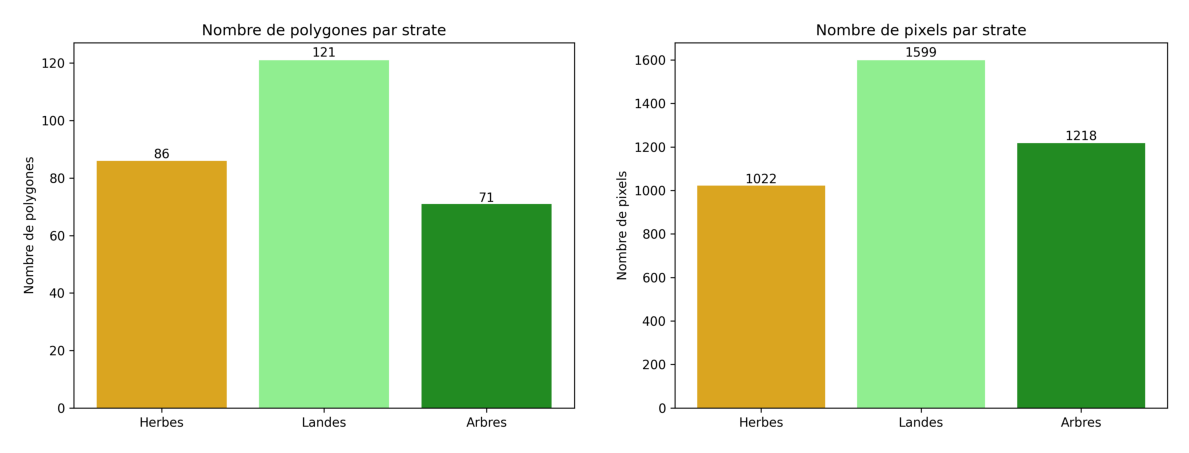

In [6]:
diag_poly = mpimg.imread(os.path.join(figure_path, "diag_baton_nb_poly_by_class.png"))
diag_pix = mpimg.imread(os.path.join(figure_path, "diag_baton_nb_pix_by_class.png"))

# Diagrammes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].imshow(diag_poly)
axes[0].axis('off')
axes[1].imshow(diag_pix)
axes[1].axis('off')
plt.tight_layout()

plt.show()


Observations :
- Pas de sols nus dans l'échantillon.
- Landes : la plus représentée (121 polygones, 1599 pixels).
- Arbres : 2ᵉ en nombre de pixels, 3ᵉ en nombre de polygones (71 polygones, 1218 pixels).
- Herbes : 3ᵉ en nombre de pixels, 2ᵉ en nombre de polygones (86 polygones, 1022 pixels).

Ces diagrammes montrent le déséquilibre des strates. On tiendra compte de ces observations dans la classification.


## 2.2. Phénologie des strates, mise en évidence des landes

### 2.2.1 Réorganisation des images Sentinel-2

Les images Sentinel-2 sont fournies sous forme de séries temporelles par bande spectrale : chaque fichier correspond à une bande (B02, B03…) contenant les acquisitions des six dates (mars à août 2025). Pour faciliter les analyses, on crée pour chaque date une image multibande regroupant toutes les bandes spectrales.

In [7]:
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(data_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        single_band = arr[:, :, i]            # extraire la date correspondante
        band_arrays.append(np.atleast_3d(single_band))
    
    # Empiler toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)       # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(data_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(data_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")


Fichier créé pour 2025-03-31 -> /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif
Fichier créé pour 2025-04-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-04-10.tif
Fichier créé pour 2025-05-15 -> /home/onyxia/work/data/projet_eval/bretagne_2025-05-15.tif
Fichier créé pour 2025-06-17 -> /home/onyxia/work/data/projet_eval/bretagne_2025-06-17.tif
Fichier créé pour 2025-07-12 -> /home/onyxia/work/data/projet_eval/bretagne_2025-07-12.tif
Fichier créé pour 2025-08-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-08-10.tif


### 2.2.2 Calcul ARI

L’ARI (Anthocyanin Reflectance Index) est utilisé ici comme indicateur de stress ou de sénescence végétale, permettant de mettre en évidence des différences phénologiques entre strates au cours de la saison de croissance. Calcul à partir des bandes Sentinel-2 B03 (vert) et B05 (red-edge)

In [8]:
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]
ari_list = []

for date in dates:
    filename = os.path.join(data_path, f"bretagne_{date}.tif")
    img = rw.load_img_as_array(filename).astype("float32")

    # Bandes B03 et B05
    b03, b05 = img[:, :, 1], img[:, :, 3]
    # Masque pixels valides, éviter divisions par zéro
    mask_valid = (b03 > 0) & (b05 > 0)
    # Tableau ARI initialisé avec NoData
    ari = np.full(b03.shape, -9999, dtype="float32")
    # Calcul ARI uniquement sur pixels valides
    ari[mask_valid] = (
        (1.0 / b03[mask_valid] - 1.0 / b05[mask_valid]) /
        (1.0 / b03[mask_valid] + 1.0 / b05[mask_valid]))
    # Ajout à la liste pour empilement temporel
    ari_list.append(ari[:, :, np.newaxis])

# Empilement temporel
ari_stack = np.concatenate(ari_list, axis=2)

rw.write_image(
    os.path.join(results_path, "ARI_serie_temp.tif"),
    ari_stack,
    data_set=rw.open_image(os.path.join(data_path, f"bretagne_{dates[0]}.tif")),
    gdal_dtype=gdal.GDT_Float32)

### 2.2.3. Série temporelle, moyenne et écarts types

Reconnaître les signatures spectrales et leur évolution temporelle.

In [9]:
# Extraire valeurs ARI des pixels d'échantillons
X, Y, _ = cla.get_samples_from_roi(os.path.join(results_path, "ARI_serie_temp.tif"), roi_raster)

# Convertir en DataFrame
df = pd.DataFrame(X, columns=dates)
df['strate'] = Y.flatten()
df.replace(-9999, np.nan, inplace=True)

# Moyenne et écart-type par strate
mean_df = df.groupby('strate').mean()
std_df  = df.groupby('strate').std()

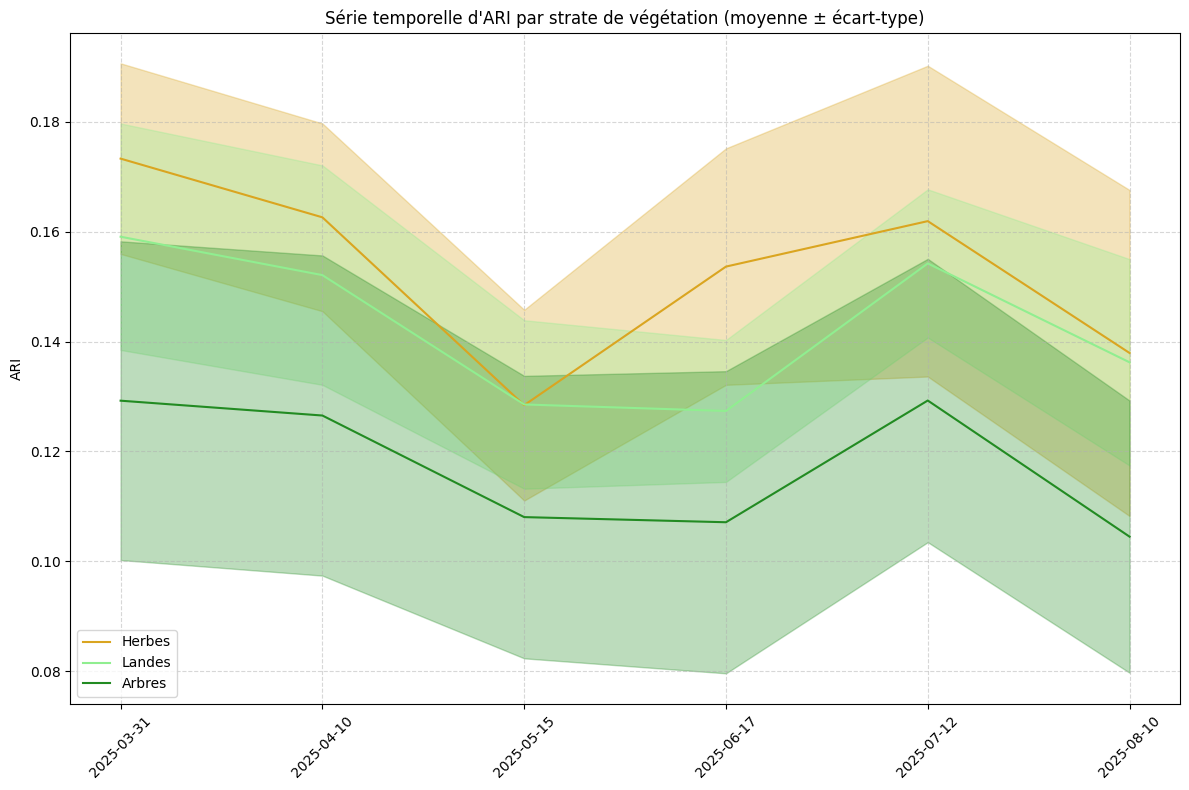

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(dates))

for strate in mean_df.index:
    means = mean_df.loc[strate].values
    stds = std_df.loc[strate].values
    ax.plot(x, means, color=colors_strates[strate], label=labels_strates[strate])
    ax.fill_between(x, means - stds, means + stds, color=colors_strates[strate], alpha=0.3)

ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45)
ax.set_ylabel("ARI")
ax.set_title("Série temporelle d'ARI par strate de végétation (moyenne ± écart-type)")
ax.legend(loc='lower left', frameon=True)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "ARI_series.png"), dpi=300)
plt.show()


Les courbes des trois strates sont proches et les écarts types se chevauchent
Si la courbe des landes est distincte dans le temps des autres strates, surtout à certaines dates (ex. pic automnal dû aux anthocyanes), alors on peut dire que le ARI permet de distinguer la lande. On a pas de date en automne 

L’analyse des signatures ARI met en évidence les tendances phénologiques des trois strates de végétation. Globalement, les valeurs moyennes suivent l’ordre Herbes > Landes > Arbres, avec des valeurs plus élevées en mars et en juillet. 
Pour les landes, l’ARI moyen varie entre 0,13 et 0,16 de mars à août, avec une baisse notable en mai-juin avant une remontée en juillet.
Les strates Herbes et Landes présentent des valeurs proches et des écarts-types qui se chevauchent, leurs trajectoires sont similaires. 
Cela suggère qu’un modèle de classification basé uniquement sur l’ARI pourrait avoir du mal à les différencier. Les landes se distinguent plus clairement des arbres, leur ARI étant systématiquement plus élevée.
L’examen des écarts-types confirme que l’ARI permet de dégager des tendances phénologiques, mais ne suffit pas à assurer une séparation parfaite entre toutes les strates sans l’appui d’autres bandes spectrales ou indices. En résumé, l’ARI constitue un indicateur utile pour caractériser la phénologie des landes, mais son pouvoir discriminant reste limité vis-à-vis des autres strates.

---

# 3. Production d’une carte de strates à l’échelle du pixel

L’objectif est de produire une carte spatiale des strates de végétation à partir des images Sentinel-2, puis d’évaluer la qualité de la classification à l’aide des échantillons terrain.

## 3.1 Préparation des données
La classification repose sur l’ensemble des bandes spectrales Sentinel-2 disponibles ainsi que sur l’indice ARI calculé pour chaque date d’acquisition. Au total, 11 variables par date sur 6 dates sont utilisées, soit 66 variables explicatives par pixel.
Les images multi-bandes sont empilées sur la dimension spectrale afin de constituer un raster unique servant de base à l’apprentissage et à la prédiction.

In [ ]:
stack_list = []

# Liste de toutes les images multibandes par date
for date in dates:
    img_file = os.path.join(data_path, f"bretagne_{date}.tif")
    img = rw.load_img_as_array(img_file)
    stack_list.append(img)

# Ajouter ARI
ari_file = os.path.join(results_path, "ARI_serie_temp.tif")
ari_img = rw.load_img_as_array(ari_file)
stack_list.append(ari_img)

# Concaténation
full_stack = np.dstack(stack_list)  # shape = lignes x colonnes x n_variables
print("Full stack shape:", full_stack.shape)

Full stack shape: (612, 1533, 66)


In [ ]:
# Rasteriser le champ 'id'
in_vector = os.path.join(data_path, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(data_path, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.join(data_path, 'PI_strates_bretagne_32630_raster_id.tif')
ref_image = rw.open_image(ref_image)
nb_lignes, nb_col, _ = rw.get_image_dimension(ref_image)
origin_x, origin_y = rw.get_origin_coordinates(ref_image)
psize_x, psize_y = rw.get_pixel_size(ref_image)

xmin, xmax = origin_x, origin_x + nb_col * psize_x
ymax, ymin = origin_y, origin_y + nb_lignes * psize_y
sptial_res = abs(psize_x)

print("Spatial resolution :", sptial_res)
print("Extent : xmin =", xmin, "ymin =", ymin, "xmax =", xmax, "ymax =", ymax)

# Rasterisation avec GDAL (terminal) sur le champ 'id'
cmd = (
    f"gdal_rasterize -a id "       # champ à rasteriser
    f"-tr {sptial_res} {sptial_res} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    f"-ot Int32 -of GTiff "        # type entier 32 bits pour ID
    f"{in_vector} {out_image}")
os.system(cmd)

Spatial resolution : 10.0
Extent : xmin = 432950.0 ymin = 5362770.0 xmax = 448280.0 ymax = 5368890.0
0...10...20...30...40...50...60...70...80...90...100 - done.


0

## 3.2. Choix du classifieur et sa paramètrisation

Pour la classification supervisée des strates, nous avons choisi le classifieur RandomForestClassifier de la bibliothèque scikit-learn.
Cette méthode repose sur l’assemblage de multiples arbres de décision et permet de limiter le sur-apprentissage tout en conservant une grande capacité d’apprentissage.

Split train/test et validation croisée

Optimisation des hyperparamètres avec RF

RF sensible au déséquilibre de classes
On utilise stratify=Y dans le split pour préserver la proportion des classes. plus maintenant?

f1_weighted prend en compte le déséquilibre de classes. plutot que accuracy (mais métrique utilisée en cours)
L’optimisation des hyperparamètres du classifieur a été réalisée via une recherche sur grille (GridSearchCV) afin d’identifier la combinaison qui maximise la capacité du modèle à généraliser aux données non vues.

Le déséquilibre numérique entre les classes justifie techniquement l'usage du StratifiedGroupKFold. Cette méthode assure que chaque classe, même minoritaire, est représentée de manière équitable lors de la validation croisée, garantissant ainsi la fiabilité des scores de précision finaux.

scoring: f1 + accuracy, différence? lequel choisir? cours Yousra

Les pixels issus d’un même polygone pouvant présenter une forte autocorrélation spatiale, une validation croisée classique aurait conduit à une surestimation des performances. Afin d’éviter toute fuite d’information entre les jeux d’apprentissage et de test, une stratégie de validation basée sur des groupes spatiaux (StratifiedGroupKFold) a été mise en œuvre, chaque groupe correspondant à un polygone d’échantillonnage terrain.

In [34]:
# Extraire X, y et groupes
X, y, _ = cla.get_samples_from_roi(full_stack_file, os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif'))
_, groups, _ = cla.get_samples_from_roi(full_stack_file, out_image)
y = np.asarray(y).ravel()
groups = np.asarray(groups).ravel()

# Charger le raster des groupes
# groups_raster = rw.open_image(out_image)
#groups_full = groups_raster.GetRasterBand(1).ReadAsArray()
#groups = groups_full[t[0], t[1]]  # pixels correspondants

print("X :", X.shape, "y :", y.shape, "groups :", groups.shape)

X : (3839, 66) y : (3839,) groups : (3839,)


In [35]:
# Split train/test par polygone
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(gss.split(X, y, groups=groups)) # groups contient l'ID du polygone pour chaque pixel

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

print(f"Train pixels : {X_train.shape[0]}, Test pixels : {X_test.shape[0]}")
print(f"Train groups : {len(np.unique(groups_train))}, Test groups : {len(np.unique(groups_test))}")

Train pixels : 2676, Test pixels : 1163
Train groups : 67, Test groups : 30


In [ ]:
# Définir le classifieur et la grille d'hyperparamètres
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5]}

# StratifiedGroupKFold sur le train
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    return_train_score=True)

# Optimisation
grid_search.fit(X_train, y_train, groups=groups_train) 
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur F1-weighted CV :", grid_search.best_score_)

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Meilleur F1-weighted CV : 0.0


In [ ]:
# Score moyen CV
print(f"Score CV moyen : {grid_search.best_score_:.2f}")

# Evaluation sur le test
y_pred = best_model.predict(X_test)
print("Classification report sur test set :")
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score test : {f1:.3f}")

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Score CV moyen : 0.00
Classification report sur test set :
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      51.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00      44.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00      55.0
          11       0.00      0.00      0.00      77.0
          12       0.00      0.00      0.00      72.0
          13       0.00      0.00      0.00      38.0
          14       0.00      0.00      0.00       0.0
          15     

/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/s

## 3.3. Stratégie de validation

Après GridSearch, tu peux examiner l’importance des variables via best_model.feature_importances_ pour voir quelles bandes ou dates sont les plus discriminantes.

In [ ]:
# Écart-type CV
cv_results = pd.DataFrame(grid_search.cv_results_)
best_index = grid_search.best_index_
print(f"Écart-type CV du meilleur modèle : " f"{cv_results.loc[best_index, 'std_test_score']:.3f}")

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n" cm)

# Analyse détaillée des résultats GridSearch
df_results = pd.DataFrame({
    "n_estimators": cv_results["param_n_estimators"],
    "max_depth": cv_results["param_max_depth"],
    "max_features": cv_results["param_max_features"],
    "min_samples_leaf": cv_results["param_min_samples_leaf"],
    "mean_test_score": cv_results["mean_test_score"],
    "std_test_score": cv_results["std_test_score"],
    "rank_test_score": cv_results["rank_test_score"]
})
# Afficher les 10 meilleures combinaisons
df_results.sort_values("rank_test_score").head(10)

In [ ]:
# Étape 6 : Évaluation sur le jeu de test indépendant
# -------------------------------------------------
y_pred = best_model.predict(X_test)
print("Classification report sur test set :\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy test : {accuracy:.3f}, F1-score test : {f1:.3f}")


Matrice de confusion

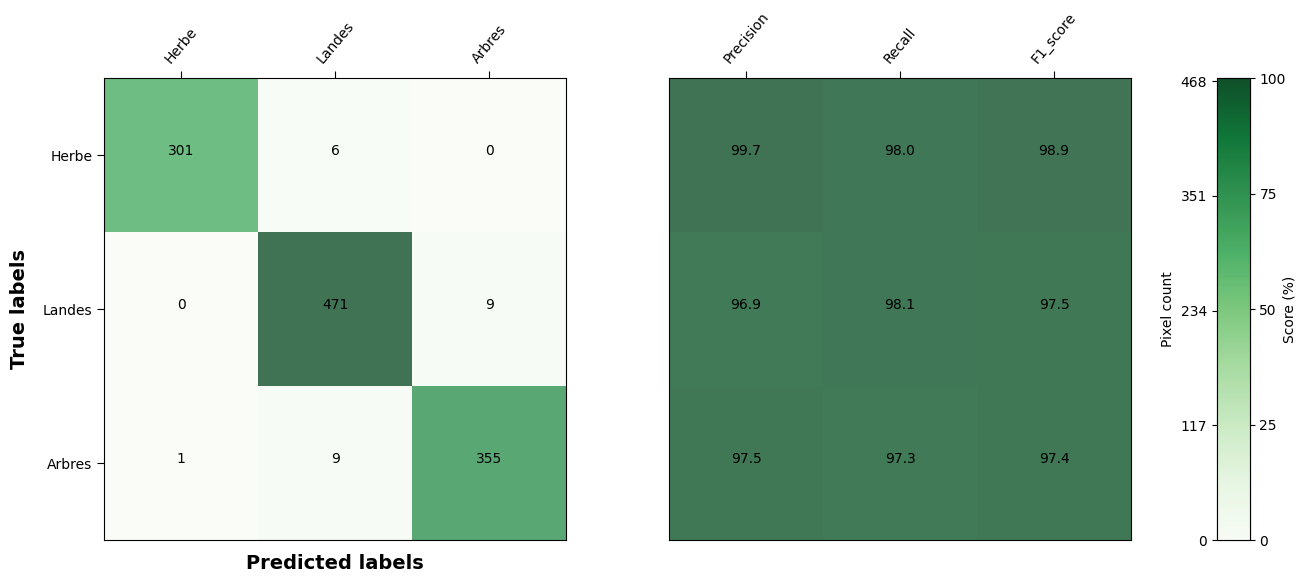

In [ ]:
plots.plot_cm(cm, labels=['Herbe', 'Landes', 'Arbres'])

Qualité des classes

In [ ]:
report = classification_report(y_test, y_pred, labels=np.unique(y_test), output_dict=True)
# Affiche tout le dictionnaire
print(report)
print()

report_df = pd.DataFrame.from_dict(report)
report_df

# keep columns
report_df = report_df.loc[:, ['2', '3', '4']]
# drop rows (axis=0, same as numpy)
report_df = report_df.drop(['support'], axis=0)
report_df

{'2': {'precision': 0.9966887417218543, 'recall': 0.9804560260586319, 'f1-score': 0.9885057471264368, 'support': 307.0}, '3': {'precision': 0.9691358024691358, 'recall': 0.98125, 'f1-score': 0.9751552795031055, 'support': 480.0}, '4': {'precision': 0.9752747252747253, 'recall': 0.9726027397260274, 'f1-score': 0.9739368998628258, 'support': 365.0}, 'accuracy': 0.9782986111111112, 'macro avg': {'precision': 0.9803664231552385, 'recall': 0.9781029219282198, 'f1-score': 0.9791993088307893, 'support': 1152.0}, 'weighted avg': {'precision': 0.9784235274471086, 'recall': 0.9782986111111112, 'f1-score': 0.9783270546694776, 'support': 1152.0}}



,2,3,4
precision,0.996689,0.969136,0.975275
recall,0.980456,0.981250,0.972603
f1-score,0.988506,0.975155,0.973937


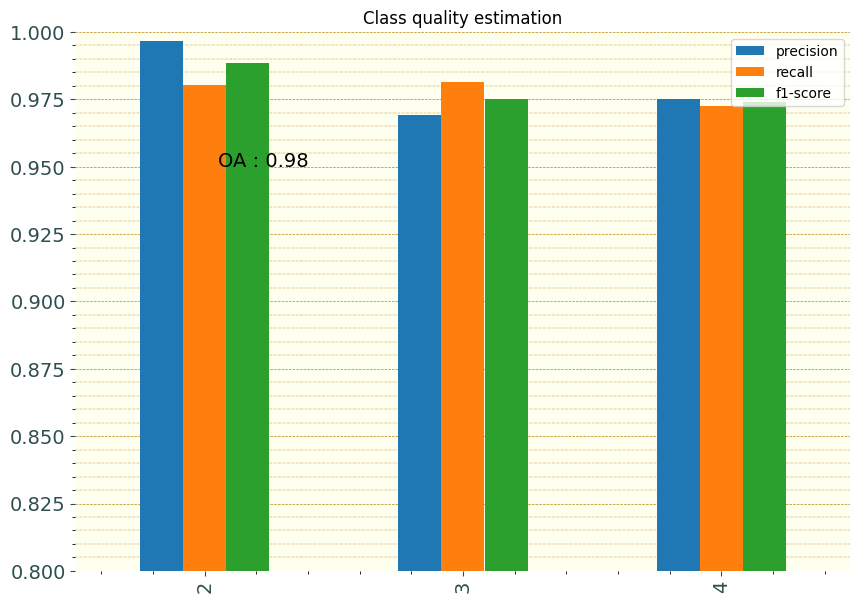

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax = report_df.T.plot.bar(ax=ax, zorder=2)

# custom : information
ax.set_ylim(0.8, 1)
ax.text(0.05, 0.95, 'OA : {:.2f}'.format(accuracy), fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
                      linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
                      linewidth=0.3, zorder=1)

Ajouter la barre d'erreurs

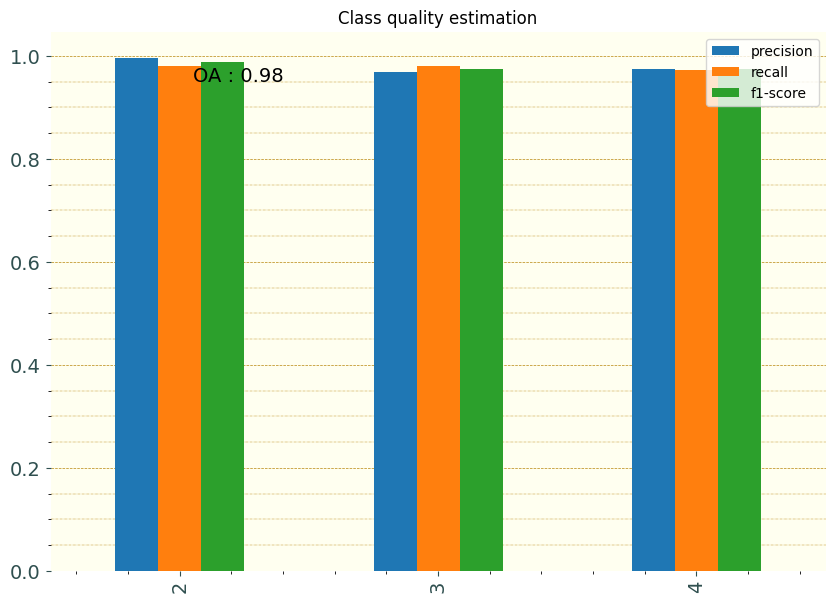

In [ ]:
plots.plot_class_quality(report, accuracy) #out_filename=out_qualite

## 3.4. Contribution des variables

In [ ]:
# Contribution des variables
contributions = best_model.feature_importances_

# Noms des variables : toutes les bandes pour chaque date + ARI
band_names = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
ari_dates = dates
features = [f"{band}_{date}" for date in dates for band in band_names] + [f"ARI_{date}" for date in dates]

# dataframe
df_contributions = pd.DataFrame({
    "feature": features,
    "contribution": contributions
})

# trier par contribution
df_contributions.sort_values("contribution", ascending=False, inplace=True)

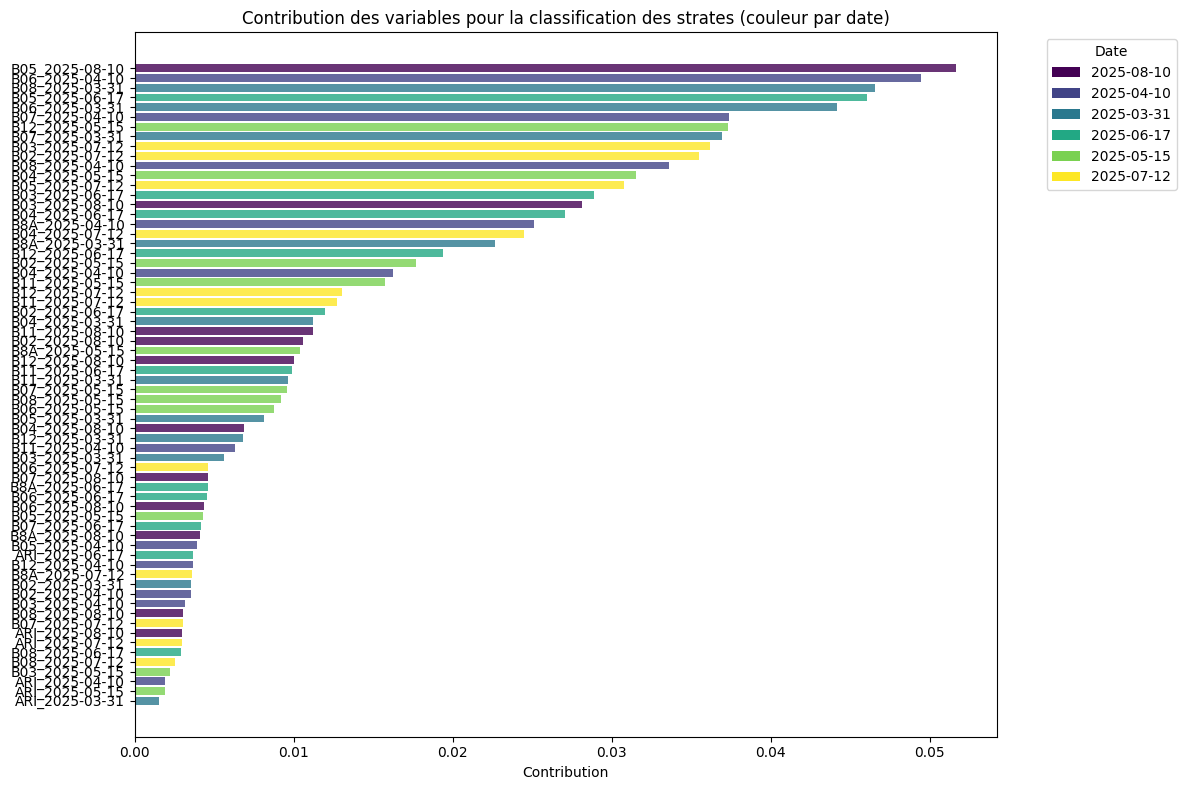

In [ ]:
#import matplotlib.cm as cm
#import matplotlib.colors as mcolors

# extraire la date depuis le nom des features
df_contributions["date"] = df_contributions["feature"].apply(lambda x: x.split("_")[1])

# créer une palette de couleurs pour les dates
unique_dates = df_contributions["date"].unique()
colors = cm.viridis(np.linspace(0, 1, len(unique_dates)))  # tu peux changer "viridis" par "tab10", "plasma", etc.
date_color_map = dict(zip(unique_dates, colors))

# couleur pour chaque barre
bar_colors = df_contributions["date"].map(date_color_map)

plt.figure(figsize=(12,8))
plt.barh(
    df_contributions["feature"], 
    df_contributions["contribution"], 
    color=df_contributions["date"].map(date_color_map), 
    alpha=0.8
)
plt.xlabel("Contribution")
plt.title("Contribution des variables pour la classification des strates (couleur par date)")
plt.gca().invert_yaxis()

# légende
#from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=date_color_map[d], label=d) for d in unique_dates]
plt.legend(handles=legend_elements, title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


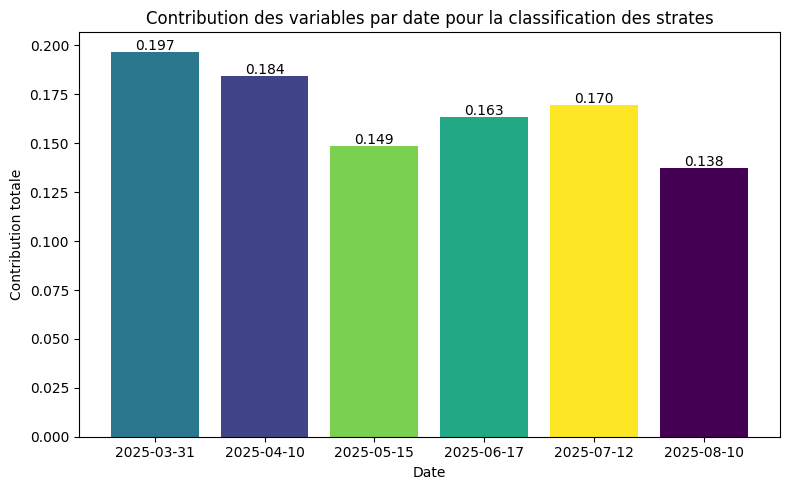

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(
    contrib_par_date.index, 
    contrib_par_date.values, 
    color=[date_color_map[d] for d in contrib_par_date.index]
)
plt.ylabel("Contribution totale")
plt.xlabel("Date")
plt.title("Contribution des variables par date pour la classification des strates")

# ajouter les valeurs
for i, v in enumerate(contrib_par_date.values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

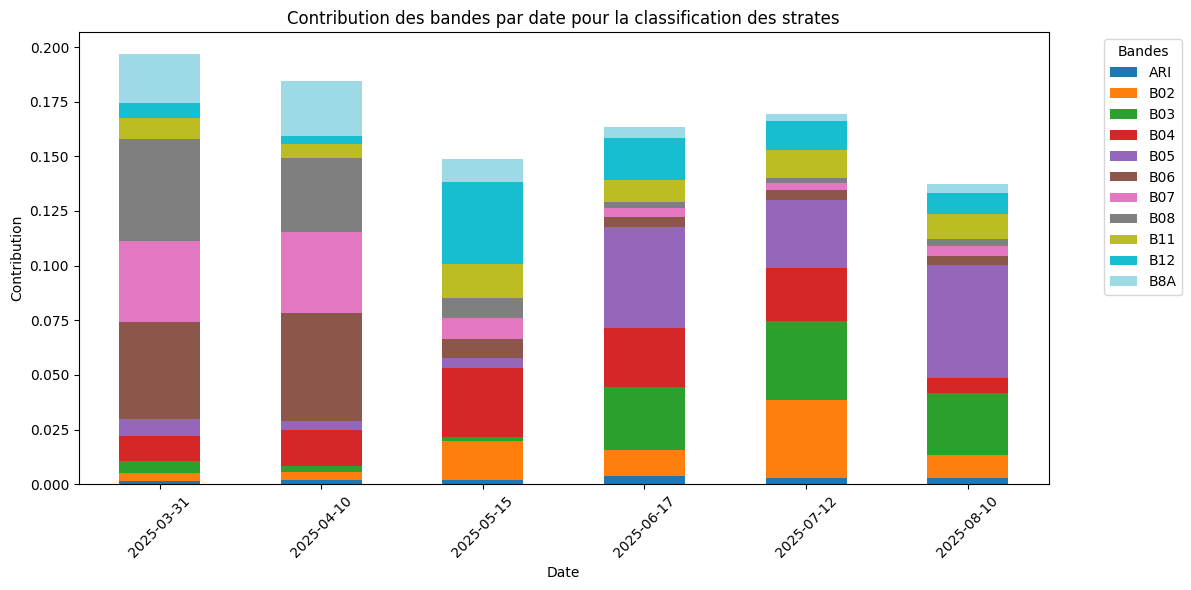

In [ ]:
pivot_df = df_contributions.pivot_table(index="date", columns="band", values="contribution", aggfunc="sum")
pivot_df.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6), 
    colormap="tab20"  # couleurs différentes pour chaque bande
)
plt.ylabel("Contribution")
plt.xlabel("Date")
plt.title("Contribution des bandes par date pour la classification des strates")
plt.xticks(rotation=45)
plt.legend(title="Bandes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

# 4. Production des cartes finales

La classification a été appliquée à l’ensemble des pixels de l’image empilée.
Afin d’éviter l’attribution de classes à des pixels situés hors de l’emprise spatiale valide, un masque basé sur les valeurs NoData de l’image de référence a été appliqué a posteriori sur la carte de prédiction.
Les pixels masqués ont été codés à 0 (NoData).

In [ ]:
# -----------------------------
# 1. Charger les données empilées
# -----------------------------
full_stack_file = os.path.join(results_path, "full_stack.tif")
img_stack = rw.load_img_as_array(full_stack_file)  # shape: lignes x colonnes x n_features

# récupérer dimensions
n_rows, n_cols, n_features = img_stack.shape

# -----------------------------
# 2. Préparer les données pour la prédiction
# -----------------------------
X_pred = img_stack.reshape(-1, n_features)  # transformer en n_pixels x n_features
X_pred = np.nan_to_num(X_pred, nan=-9999)   # remplacer les NoData si nécessaire

# -----------------------------
# 3. Prédire avec le modèle optimisé
# -----------------------------
y_pred_flat = best_model.predict(X_pred)

# -----------------------------
# 4. Reshape pour revenir à la taille d'origine
# -----------------------------
y_pred_raster = y_pred_flat.reshape(n_rows, n_cols)

# -----------------------------
# 5. Fixer le NoData et type uint8
# -----------------------------
# Charger le raster de référence pour le masque d’emprise
ds_ref = rw.open_image(full_stack_file)
ref_data = ds_ref.GetRasterBand(1).ReadAsArray()

# Appliquer le masque : pixels hors emprise → 0
y_pred_raster[np.isnan(ref_data)] = 0


# -----------------------------
# 6. Sauvegarder la carte finale
# -----------------------------
carte_file = os.path.join(results_path, "carte_strates.tif")
rw.write_image(
    carte_file,
    y_pred_raster,
    data_set=rw.open_image(full_stack_file),
    gdal_dtype=gdal.GDT_Byte
)

y_pred_raster = y_pred_raster.astype(np.uint8)

carte_file = os.path.join(results_path, "carte_strates.tif")
rw.write_image(
    carte_file,
    y_pred_raster,
    data_set=ds_ref,
    gdal_dtype=gdal.GDT_Byte
)

print("Carte des strates produite :", carte_file)

band = ds_ref.GetRasterBand(1)
nodata_value = band.GetNoDataValue()
print("NoData value :", nodata_value)

Carte des strates produite : /home/onyxia/work/results/carte_strates.tif


---

# 5. Analyse des résultats

In [ ]:
# extraire X et Y pour les échantillons
X_test_samples, Y_test_samples, _ = cla.get_samples_from_roi(full_stack_file, roi_raster)
X_test_samples = np.nan_to_num(X_test_samples, nan=-9999)
Y_test_samples = Y_test_samples.ravel()

# prédiction sur les échantillons
Y_pred_samples = best_model.predict(X_test_samples)

# rapport
print(classification_report(Y_test_samples, Y_pred_samples))
print(confusion_matrix(Y_test_samples, Y_pred_samples))


              precision    recall  f1-score   support

           2       1.00      0.99      1.00      1022
           3       0.99      0.99      0.99      1599
           4       0.99      0.99      0.99      1218

    accuracy                           0.99      3839
   macro avg       0.99      0.99      0.99      3839
weighted avg       0.99      0.99      0.99      3839

[[1016    6    0]
 [   0 1590    9]
 [   1    9 1208]]


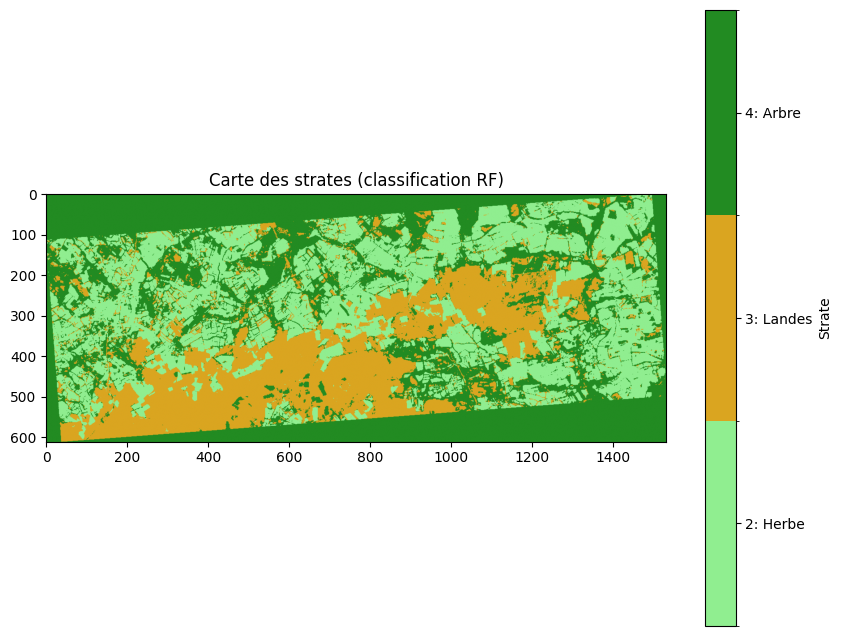

In [ ]:
#from matplotlib.colors import ListedColormap, BoundaryNorm

# Classes discrètes
classes = [2, 3, 4]

# Couleurs correspondantes
colors = ['lightgreen', 'goldenrod', 'forestgreen']

# Créer colormap et normalisation pour classes discrètes
cmap = ListedColormap(colors)
norm = BoundaryNorm([1.5, 2.5, 3.5, 4.5], cmap.N)  # bornes pour 2,3,4

plt.figure(figsize=(10,8))
im = plt.imshow(y_pred_raster, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=classes)
cbar.set_label('Strate')
cbar.ax.set_yticklabels(['2: Herbe', '3: Landes', '4: Arbre'])  # optionnel : nom des classes
plt.title("Carte des strates (classification RF)")
plt.show()

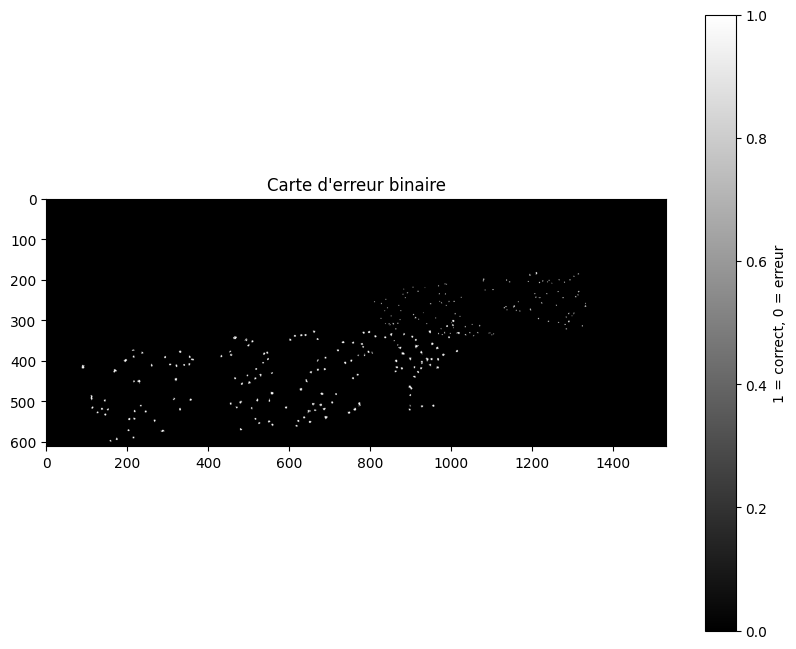

In [ ]:
# INVERSE
# 
# S'assurer que les rasters sont 2D
Y_raster = np.squeeze(Y_raster)        # supprime l'axe singleton si existant
y_pred_raster = np.squeeze(y_pred_raster)

# Créer la carte d'erreur binaire
error_map = np.zeros_like(Y_raster, dtype=np.uint8)

# Pixels valides : Y_raster != 0
valid_mask = Y_raster != 0

# Correct = 1, erreur = 0
error_map[valid_mask] = (y_pred_raster[valid_mask] == Y_raster[valid_mask]).astype(np.uint8)

# Affichage
plt.figure(figsize=(10,8))
cmap = plt.cm.gray  # 0 = erreur, 1 = correct
plt.imshow(error_map, cmap=cmap)
plt.colorbar(label='1 = correct, 0 = erreur')
plt.title("Carte d'erreur binaire")
plt.show()


afficher dans img RGB + couleur par classes

QGIS comparer classif polygones (vecteur ou rasterisé?) + carte classif